In [1]:
# @title 1. System Setup and Imports
import sys
import os

# Install required packages quietly
print("Initializing system environment...")
!apt-get update > /dev/null
!apt-get install -y swig > /dev/null
!pip install gymnasium[box2d] stable-baselines3 shimmy moviepy > /dev/null

# Import libraries
import gymnasium as gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
from gymnasium.wrappers import RecordVideo

# Verify GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
gpu_name = torch.cuda.get_device_name(0) if device == "cuda" else "Unknown"

print(f"System Ready. Device: {device.upper()} [{gpu_name}]")
if "A100" in gpu_name:
    print("A100 GPU detected.")

Initializing system environment...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
System Ready. Device: CUDA [NVIDIA A100-SXM4-40GB]
A100 GPU detected.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
# @title 2. Domain Randomization Wrapper

class ColorRandomizationWrapper(gym.ObservationWrapper):
    """
    Applies random noise to the RGB channels of the observation.
    This simulates sensor noise and varying lighting conditions (Domain Randomization)
    to improve the agent's robustness to visual perturbations.
    """
    def __init__(self, env):
        super().__init__(env)

    def observation(self, obs):
        # Generate random integer noise between -50 and 50
        noise = np.random.randint(-50, 50, size=obs.shape, dtype=np.int16)

        # Apply noise and clip values to valid pixel range [0, 255]
        obs_noisy = np.clip(obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return obs_noisy

print("Domain Randomization Wrapper defined.")

Domain Randomization Wrapper defined.


In [3]:
# @title 3. Model Training

def make_env(rank, seed=0):
    def _init():
        env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
        env = ColorRandomizationWrapper(env)  # Apply domain randomization
        env.reset(seed=seed + rank)
        return env
    return _init

def train_agent():
    print("Starting parallel training.")

    # Configuration for A100
    num_cpu = 16                # Number of parallel environments
    total_timesteps = 2_000_000 # Total training steps (2M)

    # Initialize vectorized environment
    env = SubprocVecEnv([make_env(i) for i in range(num_cpu)])
    env = VecFrameStack(env, n_stack=4)

    # Initialize PPO model
    model = PPO(
        "CnnPolicy",
        env,
        verbose=1,
        learning_rate=3e-4,
        n_steps=512,        # Steps per env per update
        batch_size=2048,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.01,      # Entropy coefficient for exploration
        device=device
    )

    # Checkpoint callback to save progress
    checkpoint_callback = CheckpointCallback(
        save_freq=100000 // num_cpu,
        save_path='./logs/',
        name_prefix='a100_racer'
    )

    # Begin training
    print(f"Training on {num_cpu} environments for {total_timesteps} steps...")
    model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)

    # Save final model
    model_name = "robust_visual_pilot"
    model.save(model_name)
    print(f"Training complete. Model saved as '{model_name}.zip'.")
    return model

# Execute training
if __name__ == "__main__":
    model = train_agent()

Starting parallel training.
Using cuda device
Wrapping the env in a VecTransposeImage.
Training on 16 environments for 2000000 steps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------
| time/              |      |
|    fps             | 404  |
|    iterations      | 1    |
|    time_elapsed    | 20   |
|    total_timesteps | 8192 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 357          |
|    iterations           | 2            |
|    time_elapsed         | 45           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0045925383 |
|    clip_fraction        | 0.0372       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | -0.00366     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.338        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00375     |
|    std                  | 0.999        |
|    value_loss           | 1.17         |
----------------

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Generating Saliency Map.
Skipping start-up animation


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


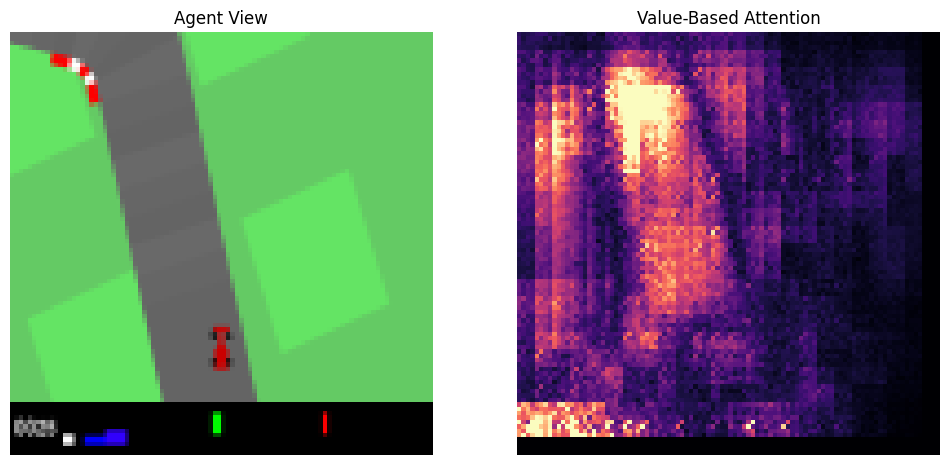

Noise Level 0: Mean Reward 246.0 ± 65.7
Noise Level 20: Mean Reward 264.2 ± 65.9
Noise Level 40: Mean Reward 257.2 ± 81.2
Noise Level 60: Mean Reward 235.6 ± 50.1
Noise Level 80: Mean Reward 254.2 ± 56.2


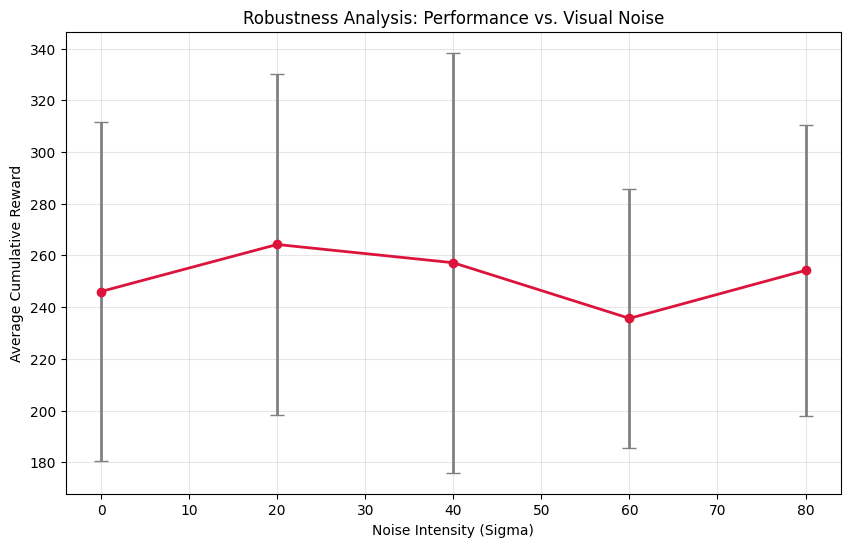

Recording demonstration video.


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Process complete. Images/Video are ready for download.


In [4]:
# @title 4. Analysis and Visualization

def compute_value_saliency(model, env):
    """
    Computes the saliency map based on the Value Function gradients.
    This visualizes the image regions the agent focuses on to estimate future rewards.
    """
    obs = env.reset()

    # Skip initial zoom animation (first 50 frames)
    print("Skipping start-up animation")
    for _ in range(50):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _ = env.step(action)

    # VecFrameStack gives(Batch, H, W, C), so we transpose.
    single_obs = obs[0] # Remove batch dim temporarily
    obs_transposed = np.transpose(single_obs, (2, 0, 1))
    obs_tensor = torch.as_tensor(obs_transposed, device=model.device).float().unsqueeze(0)
    obs_tensor.requires_grad_()

    # Compute gradients of the Value Function
    value = model.policy.predict_values(obs_tensor)
    value.backward()

    # Process gradients
    saliency = obs_tensor.grad.abs().squeeze().cpu().numpy()
    if len(saliency.shape) == 3:
        saliency = np.mean(saliency, axis=0) # Average across stack/channels

    # Normalization
    v_min, v_max = np.percentile(saliency, 2), np.percentile(saliency, 98)
    if v_max == v_min: v_max += 1e-8
    saliency = np.clip((saliency - v_min) / (v_max - v_min), 0, 1)

    return single_obs[:, :, -3:], saliency

def plot_robustness_analysis(model):
    """Evaluates agent performance across increasing noise levels (Averaged over 5 runs)."""
    noise_levels = [0, 20, 40, 60, 80]
    mean_rewards = []
    std_rewards = []

    for noise in noise_levels:
        episode_rewards = []
        # Run 5 episodes per noise level to ensure statistical significance
        for _ in range(5):
            env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
            env = DummyVecEnv([lambda: env])
            env = VecFrameStack(env, n_stack=4)
            obs = env.reset()
            total_r = 0

            for _ in range(400): # Test horizon
                # Inject noise
                noise_mask = np.random.randint(-noise, noise+1, size=obs[0].shape) if noise > 0 else 0
                obs_noisy = np.clip(obs + noise_mask, 0, 255).astype(np.uint8)

                action, _ = model.predict(obs_noisy, deterministic=True)
                obs, r, d, _ = env.step(action)
                total_r += r[0]
                if d: break

            episode_rewards.append(total_r)
            env.close()

        mean_rewards.append(np.mean(episode_rewards))
        std_rewards.append(np.std(episode_rewards))
        print(f"Noise Level {noise}: Mean Reward {np.mean(episode_rewards):.1f} ± {np.std(episode_rewards):.1f}")

    # Plot results with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(noise_levels, mean_rewards, yerr=std_rewards,
                 fmt='-o', color='crimson', ecolor='gray', capsize=5, linewidth=2)
    plt.title("Robustness Analysis: Performance vs. Visual Noise")
    plt.xlabel("Noise Intensity (Sigma)")
    plt.ylabel("Average Cumulative Reward")
    plt.grid(True, alpha=0.3)
    plt.savefig("robustness_curve.png")
    plt.show()


# Initialize Evaluation Environment
eval_env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
eval_env = DummyVecEnv([lambda: eval_env])
eval_env = VecFrameStack(eval_env, n_stack=4)

# 1. Generate Saliency Map
print("Generating Saliency Map.")
orig_img, sal_map = compute_value_saliency(model, eval_env)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(orig_img); plt.title("Agent View"); plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sal_map, cmap='magma'); plt.title("Value-Based Attention"); plt.axis('off')
plt.savefig("saliency_map.png")
plt.show()

# 2. Perform Robustness Analysis
plot_robustness_analysis(model)

# 3. Record Demo Video
print("Recording demonstration video.")
video_env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
video_env = RecordVideo(video_env, video_folder="videos", name_prefix="demo_a100", disable_logger=True)
video_env = DummyVecEnv([lambda: video_env])
video_env = VecFrameStack(video_env, n_stack=4)

obs = video_env.reset()
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, _, _ = video_env.step(action)
video_env.close()

print("Process complete. Images/Video are ready for download.")